**Imports**

In [1]:
import pandas as pd
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,TensorDataset, DataLoader
import os 
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt 
import pytz
import seaborn as sns
from random import shuffle
from tsai.all import *
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler



**Loading annotated data**

In [2]:
data_folder = '/scratch/smartairsense/data_annotated'

prqt_file1 = os.path.join(data_folder,'annotated-office.parquet')
prqt_file2 = os.path.join(data_folder,'2022-week39.parquet')
prqt_file3 = os.path.join(data_folder,'2022-week40.parquet')
prqt_file4 = os.path.join(data_folder,'2022-week41.parquet')
prqt_file5 = os.path.join(data_folder,'2022-week42.parquet')
prqt_file6 = os.path.join(data_folder,'2022-week43.parquet')

In [3]:
data1 = pd.read_parquet(prqt_file1 , engine='fastparquet')
data2 = pd.read_parquet(prqt_file2 , engine='fastparquet')
data3 = pd.read_parquet(prqt_file3 , engine='fastparquet')
data4 = pd.read_parquet(prqt_file4 , engine='fastparquet')
data5 = pd.read_parquet(prqt_file5 , engine='fastparquet')
data6 = pd.read_parquet(prqt_file6 , engine='fastparquet')

d1 = data1.copy()
d2 = concat(data2,data3,data4,data5,data6)


d1.reset_index(drop = True,inplace = True)
d2.reset_index(drop = True,inplace = True)

d1.columns=data1.columns
d2.columns=data1.columns

# shift columns person and window_open

last_index = len(d1.columns)

person = d1.pop('person')
d1.insert(last_index-1, 'person', person)
window_open = d1.pop('window_open')
d1.insert(last_index-1, 'window_open', window_open)
person = d2.pop('person')
d2.insert(last_index-1, 'person', person)
window_open = d2.pop('window_open')
d2.insert(last_index-1, 'window_open', window_open) 

data = concat(d1,d2)
data.reset_index(drop = True,inplace=True)
data.columns=d1.columns





print(f'data shape: {data.shape}')
d2

data shape: (44106, 23)


,oxygen,pm10,co,temperature,co2,so2,no2,pm1,dewpt,timestamp,...,o3,humidity,humidity_abs,sound,pm2_5,datetime,deviceid,h2s,person,window_open
0,20.936,0.548238,1.562,24.276,455.7,-1.96,23.93,0.396847,13.985,1664150410000,...,17.96,52.009,11.546,21.94292,0.457518,2022-09-26 00:00:10+00:00,a2055772251a41b9f8bd24c66b89a09b,NaN,0,0
1,20.938,0.678546,1.562,24.274,454.4,-2.06,23.90,0.375806,13.983,1664150529000,...,18.00,52.006,11.544,21.73989,0.427543,2022-09-26 00:02:09+00:00,a2055772251a41b9f8bd24c66b89a09b,NaN,0,0
2,20.937,0.788452,1.562,24.273,454.5,-2.39,23.96,0.447566,13.997,1664150647000,...,18.06,52.056,11.554,21.70284,0.572688,2022-09-26 00:04:07+00:00,a2055772251a41b9f8bd24c66b89a09b,NaN,0,0
3,20.937,0.890764,1.562,24.271,454.5,-2.69,23.87,0.558607,13.996,1664150772000,...,18.07,52.060,11.554,21.68667,0.648710,2022-09-26 00:06:12+00:00,a2055772251a41b9f8bd24c66b89a09b,NaN,0,0
4,20.937,0.844628,1.562,24.268,455.0,-2.83,23.90,0.570323,13.995,1664150891000,...,18.00,52.066,11.553,21.76809,0.644211,2022-09-26 00:08:11+00:00,a2055772251a41b9f8bd24c66b89a09b,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24375,20.876,2.053462,1.770,22.861,478.4,-30.07,24.49,1.330274,13.696,1667173680000,...,17.39,55.583,11.384,24.44430,1.533610,2022-10-30 23:48:00+00:00,a2055772251a41b9f8bd24c66b89a09b,NaN,0,0
24376,20.879,2.696659,1.770,22.859,478.9,-30.17,24.44,1.723195,13.694,1667173799000,...,17.39,55.583,11.383,24.60689,2.125683,2022-10-30 23:49:59+00:00,a2055772251a41b9f8bd24c66b89a09b,NaN,0,0
24377,20.877,2.313910,1.770,22.856,479.0,-30.16,24.55,1.658417,13.692,1667173918000,...,17.40,55.585,11.381,24.62165,2.026718,2022-10-30 23:51:58+00:00,a2055772251a41b9f8bd24c66b89a09b,NaN,0,0
24378,20.878,2.186051,1.770,22.853,479.4,-30.27,24.58,1.707657,13.689,1667174041000,...,17.48,55.584,11.379,24.86741,2.009216,2022-10-30 23:54:01+00:00,a2055772251a41b9f8bd24c66b89a09b,NaN,0,0


**Encode target classes (person and window open) classes**

In [4]:
df1 = d1.copy()
df2 = d2.copy()
df = data.copy()

le = LabelEncoder()
le1 = LabelEncoder()
le2 = LabelEncoder()

labels = ['person','window_open']

for label in labels:
    le.fit(df[label])
    le1.fit(df1[label])
    le2.fit(df2[label])
    df[label]=le.transform(df[label])
    df1[label]=le1.transform(df1[label])
    df2[label]=le2.transform(df2[label])
    print(df[label].value_counts())
    print(df1[label].value_counts())
    print(df2[label].value_counts())

print(df.shape)

0    41876
1     2038
2      189
4        2
3        1
Name: person, dtype: int64
0    18144
1     1440
2      139
4        2
3        1
Name: person, dtype: int64
0    23732
1      598
2       50
Name: person, dtype: int64
0    42801
1     1305
Name: window_open, dtype: int64
0    18701
1     1025
Name: window_open, dtype: int64
0    24100
1      280
Name: window_open, dtype: int64
(44106, 23)


**select some columns to plot**

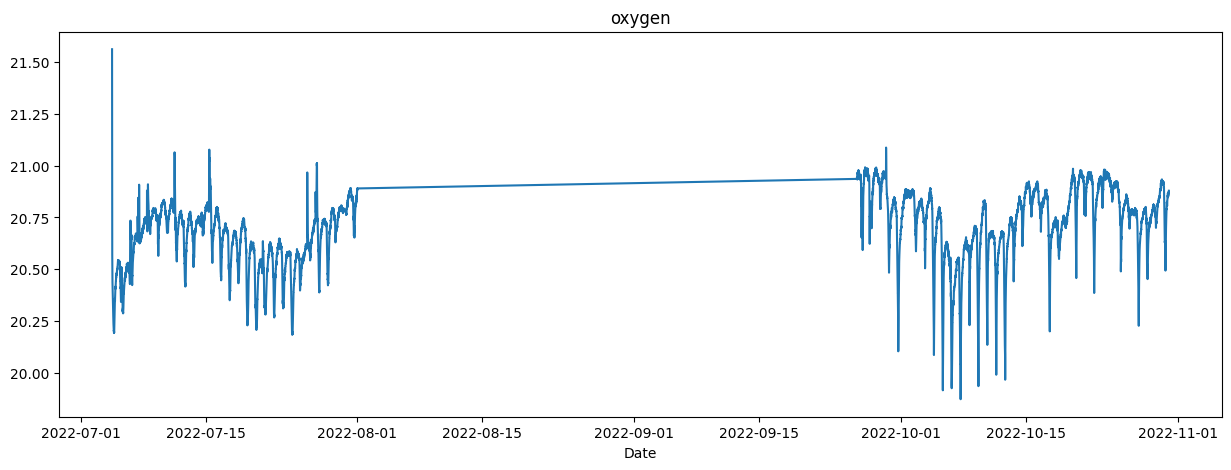

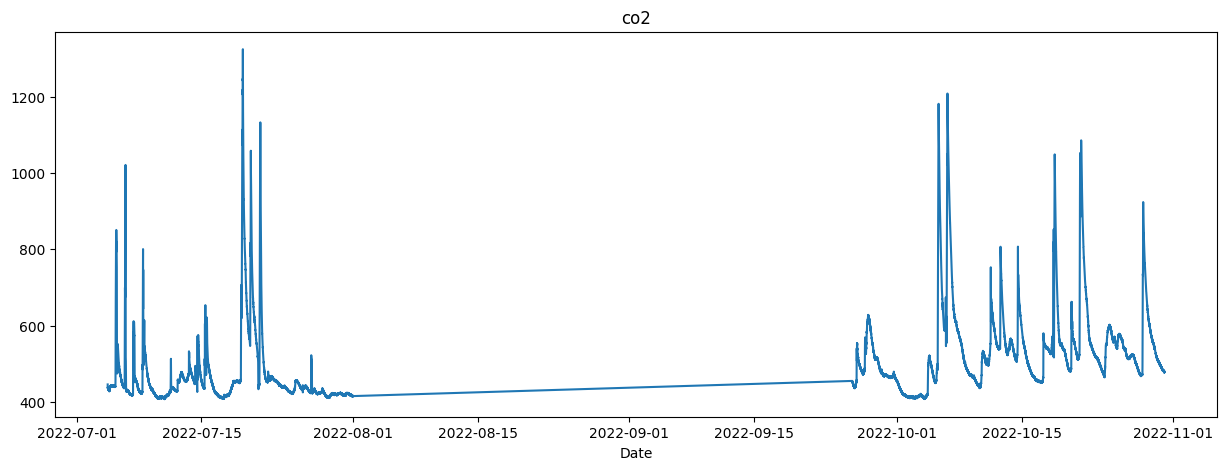

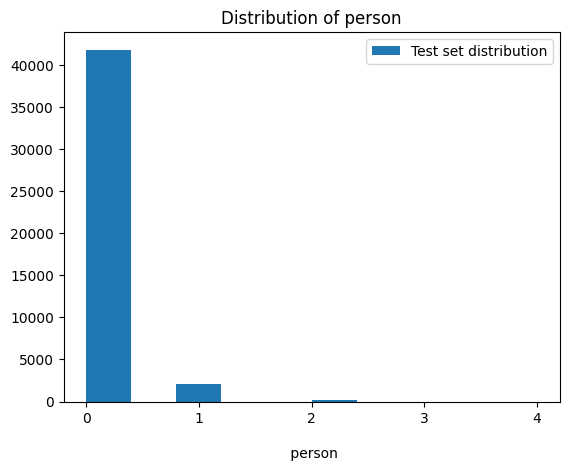

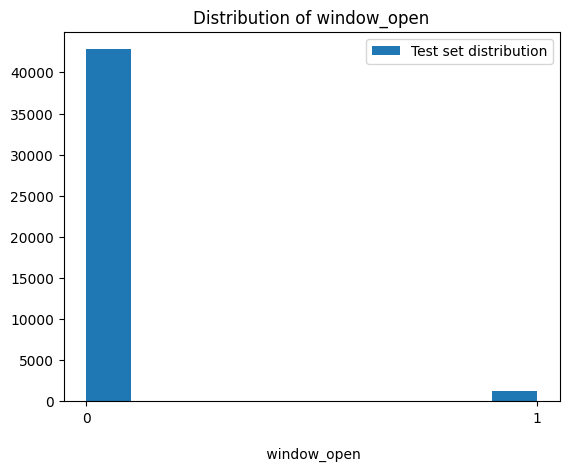

In [5]:
plot_cols = ['oxygen', 'co2','person','window_open']

x = df.datetime

# plot o2 and co2 
for col in plot_cols[0:2]:
    fig = plt.figure(figsize=(15,5))
    plt.plot(x, df[col])
    plt.xlabel('Date')
    plt.title(col)
#plot distribution of number of persons and window open
for col in plot_cols[2:]:
    fig = plt.figure()
    plt.hist(df[col],label='Test set distribution')
    plt.xlabel(f'\n {col}')
## Ticks labels - List must be in ascending order
    plt.xticks(df[col].unique()) ### names of classes starting from 0
    #sns.distplot(df[col], bins=100, kde=False)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()
    # plt.figure()
    # df[col].value_counts().plot.pie(autopct='%0.2f')



**plot scaled data in one figure**

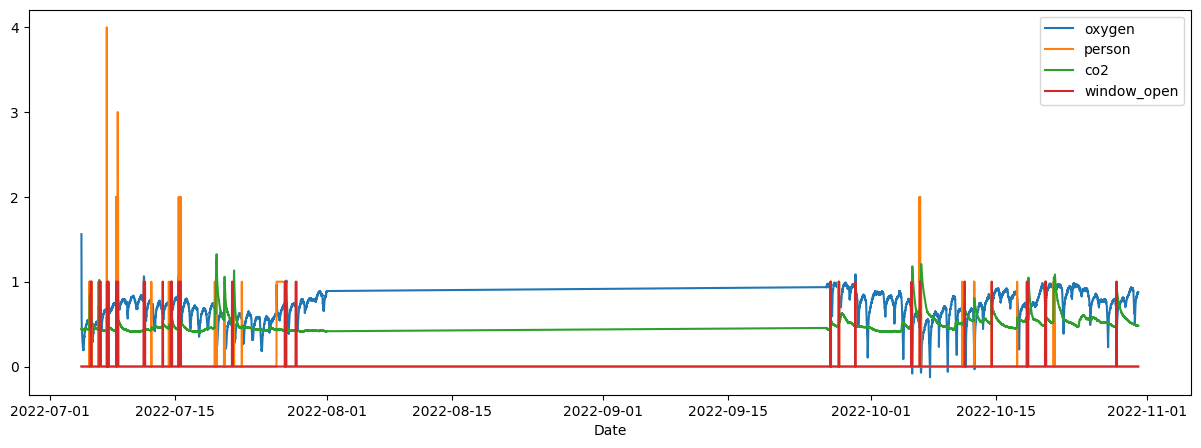

In [6]:
x = df.datetime
fig = plt.figure(figsize=(15,5))

plt.xlabel('Date')
plt.plot(x, df['oxygen']-20,label='oxygen')
plt.plot(x, df['person'],label='person')
plt.plot(x, df['co2']/1000,label='co2')
plt.plot(x, df['window_open'], label='window_open' )
plt.legend()


**filtering data**

In [7]:
# h2s column has only NaN values, also drop timestamp,datetime,deviceid
df.drop(columns=['h2s','timestamp','deviceid','datetime'],inplace=True)
df1.drop(columns=['h2s','timestamp','deviceid','datetime'],inplace=True)
df2.drop(columns=['h2s','timestamp','deviceid','datetime'],inplace=True)




**Missing values, drop NAN**

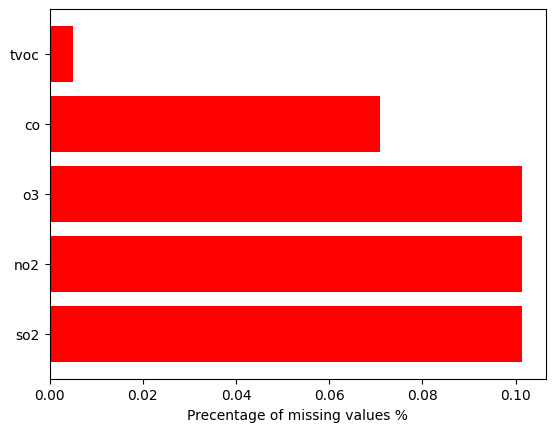

maximum number of missing values per column=  20 

   column  count  percentage
5     so2     20    0.101389
6     no2     20    0.101389
12     o3     20    0.101389
2      co     14    0.070972
9    tvoc      1    0.005069


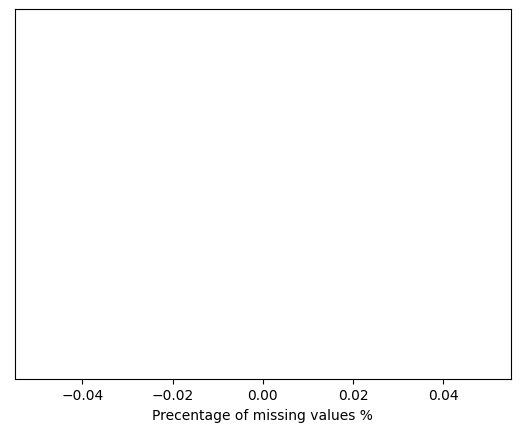

maximum number of missing values per column=  nan 

Empty DataFrame
Columns: [column, count, percentage]
Index: []


In [8]:
missing1 = df1.isnull().sum(0).reset_index()
missing2 = df2.isnull().sum(0).reset_index()
missing1.columns = ['column', 'count']
missing2.columns = ['column', 'count']

missing1 = missing1.sort_values(by = 'count', ascending = False).loc[missing1['count'] > 0]
missing1['percentage'] = missing1['count'] / float(df1.shape[0]) * 100
ind1 = np.arange(missing1.shape[0])
missing2 = missing2.sort_values(by = 'count', ascending = False).loc[missing2['count'] > 0]
missing2['percentage'] = missing2['count'] / float(df2.shape[0]) * 100
ind2 = np.arange(missing2.shape[0])

fig, ax = plt.subplots()
rects = ax.barh(ind1, missing1.percentage.values, color='r')
ax.set_yticks(ind1)
ax.set_yticklabels(missing1.column.values, rotation='horizontal')
ax.set_xlabel("Precentage of missing values %")
plt.show()
print ('maximum number of missing values per column= ',missing1['count'].max(),'\n')
print(missing1)

fig, ax = plt.subplots()
rects = ax.barh(ind2, missing2.percentage.values, color='r')
ax.set_yticks(ind2)
ax.set_yticklabels(missing2.column.values, rotation='horizontal')
ax.set_xlabel("Precentage of missing values %")
plt.show()
print ('maximum number of missing values per column= ',missing2['count'].max(),'\n')
print(missing2)

#### substitute NaN values with mean 
## polynomial interpolation with degree > 1 uses index, also convert dtype to float to work

df1.reset_index(drop=True,inplace=True)
df1.interpolate(method='polynomial', order=1,inplace=True)

df2.reset_index(drop=True,inplace=True)
df2.interpolate(method='polynomial', order=1,inplace=True)
## incase NaNs are at begining or end we drop those rows

df1.dropna(axis=0,inplace=True)
df1.reset_index(drop=True,inplace=True)

df2.dropna(axis=0,inplace=True)
df2.reset_index(drop=True,inplace=True)
##############

df = concat(df1,df2)
df.reset_index(drop=True,inplace= True)
df.columns=df1.columns






**minimized dataset for our classification task**

In [9]:

print(df['person'].value_counts(),'\n',df['window_open'].value_counts(),'\n')

#### combine classes of more than 1 person to 1 person as there exists too little of them
lc = df.loc[lambda x: x['person'] > 1]
df.loc[lc.index,'person'] = 1

lc = df1.loc[lambda x: x['person'] > 1]
df1.loc[lc.index,'person'] = 1

lc = df2.loc[lambda x: x['person'] > 1]
df2.loc[lc.index,'person'] = 1

print(df['person'].value_counts(),'\n',df['window_open'].value_counts(),'\n')

# #### remove rows with 3 (one row) and 4 person (2 rows)
# lc = df.loc[lambda x: x['person'] == 3]
# df.drop(lc.index,inplace=True)

# lc = df.loc[lambda x: x['person'] == 4]
# df.drop(lc.index,inplace=True)

# df['person'].value_counts(),df['window_open'].value_counts()

### Normalize data

targets = df.filter(['person','window_open'])
features = df.drop(columns=['person','window_open']) 


targets1 = df1.filter(['person','window_open'])
features1 = df1.drop(columns=['person','window_open']) 

targets2 = df2.filter(['person','window_open'])
features2 = df2.drop(columns=['person','window_open']) 


### minimized data

df_mini1 = df1.filter(['oxygen','co2','sound','tvoc','person','window_open'])
print(df_mini1.shape,'\n',df_mini1['person'].value_counts(),'\n',df_mini1['window_open'].value_counts(),'\n')
features_mini1 = features1.filter(['oxygen','co2','sound','tvoc'])
# print(targets1.iloc[:,0].value_counts())

df_mini2 = df2.filter(['oxygen','co2','sound','tvoc','person','window_open'])
print(df_mini2.shape,'\n',df_mini2['person'].value_counts(),'\n',df_mini2['window_open'].value_counts(),'\n')
features_mini2 = features2.filter(['oxygen','co2','sound','tvoc'])
# print(targets2.iloc[:,0].value_counts())




0.0    41856
1.0     2038
2.0      189
4.0        2
3.0        1
Name: person, dtype: int64 
 0.0    42781
1.0     1305
Name: window_open, dtype: int64 

0.0    41856
1.0     2230
Name: person, dtype: int64 
 0.0    42781
1.0     1305
Name: window_open, dtype: int64 

(19706, 6) 
 0    18124
1     1582
Name: person, dtype: int64 
 0    18681
1     1025
Name: window_open, dtype: int64 

(24380, 6) 
 0    23732
1      648
Name: person, dtype: int64 
 0    24100
1      280
Name: window_open, dtype: int64 



**Correlation Matrix, drop highly correlated features**

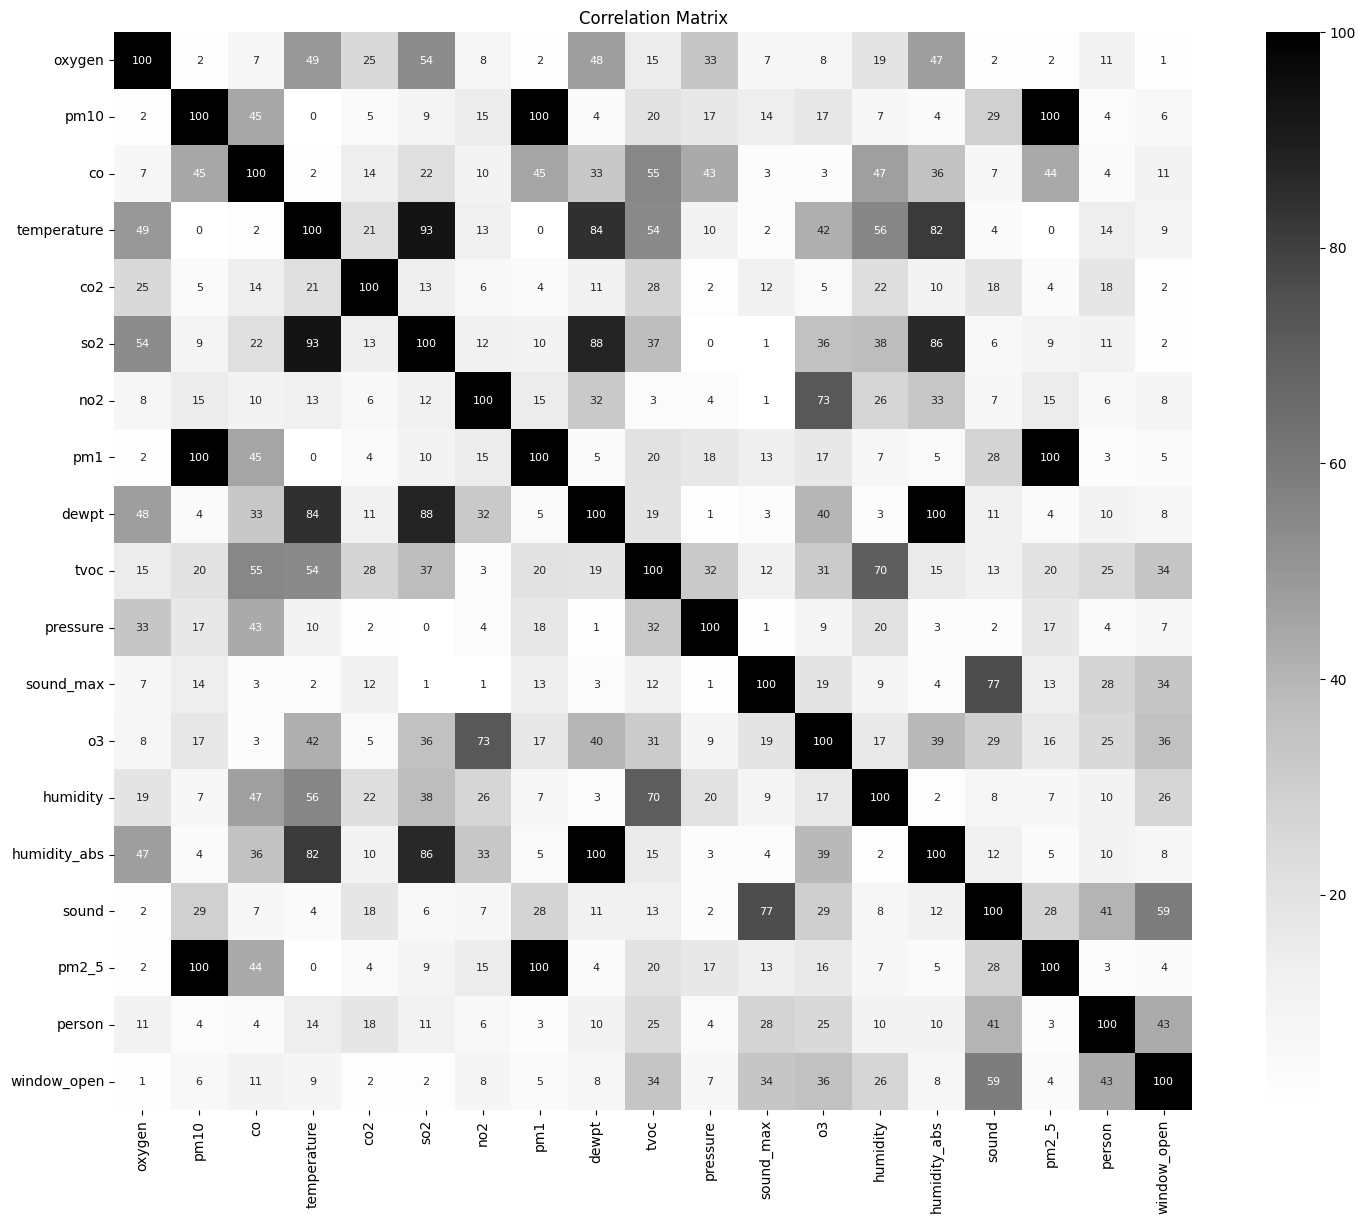

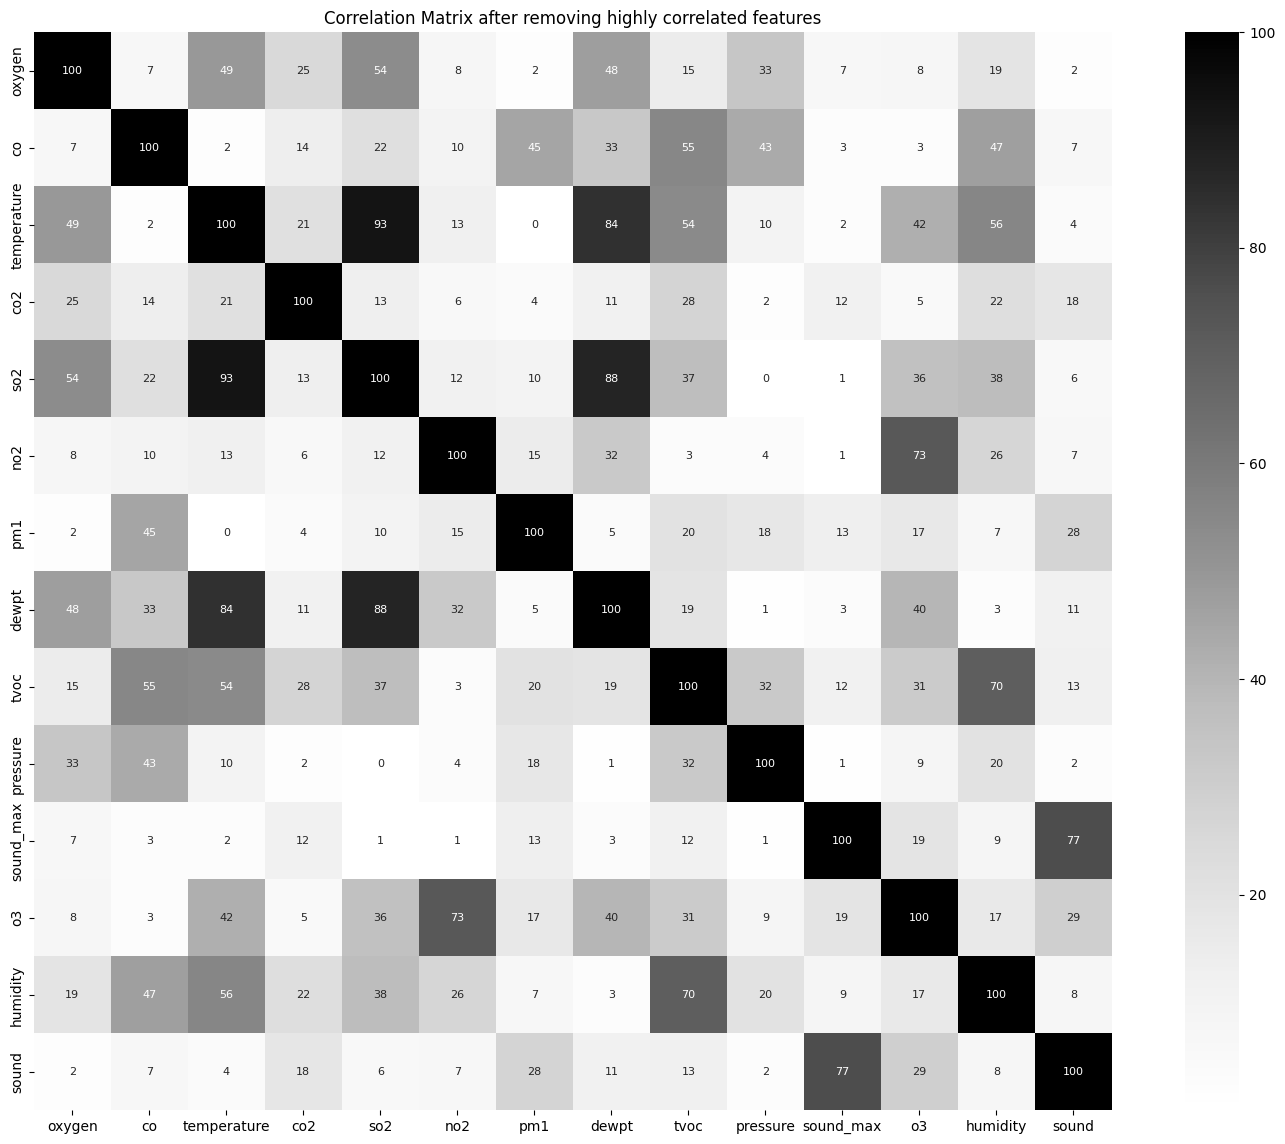

In [10]:
corr = df.corr(min_periods=1000)
high_corr = np.abs(corr)*100
f, ax = plt.subplots(figsize=(19,14))
sns.heatmap(high_corr, cbar=True,annot=True, square=True, fmt='.0f', 
            annot_kws={'size': 8},cmap='Greys')
plt.title('Correlation Matrix')
plt.show()

##### drop 100% correlated features

remove_list = ['pm10','pm2_5','humidity_abs']
features.drop(columns=remove_list,inplace=True)
features1.drop(columns=remove_list,inplace=True)
features2.drop(columns=remove_list,inplace=True)

corr = features.corr(min_periods=1000)
high_corr = np.abs(corr)*100
f, ax = plt.subplots(figsize=(19,14))
sns.heatmap(high_corr, cbar=True,annot=True, square=True, fmt='.0f', 
            annot_kws={'size': 8},cmap='Greys')
plt.title('Correlation Matrix after removing highly correlated features')
plt.show()


**Standardization function**

In [11]:
def standardize(x,**k):
    if len(k)==2:
        size = x.shape[1]
        if 'mean' in k and 'std' in k: #standard
            mean = k['mean']
            std = k['std']
            if x.ndim == 3: ### in case of segments
                x=(x-np.array(mean).reshape(1,size,1))/np.array(std).reshape(1,size,1) # to be applied tp features correctly
            elif x.ndim == 2: ### in case of data before segmentation
                x=(x-np.array(mean).reshape(1,size))/np.array(std).reshape(1,size)
        elif 'min' in k and 'max' in k: #minmax
            min = k['min']
            max = k['max']
            if x.ndim == 3:
                x=(x-np.array(min).reshape(1,size,1))/((np.array(max)-np.array(min)).reshape(1,size,1)) 
            elif x.ndim == 2:
                x=(x-np.array(min).reshape(1,size))/((np.array(max)-np.array(min)).reshape(1,size) )
    return x.astype(np.float32)

In [12]:
# ### test standardize
# t = np.array([[[1,2],[3,4]],[[5,6],[7,8]],[[5,6],[7,8]]])
# sh = t.shape
# print(t)
# # print(t - np.array([1,0]).reshape(1,2,1))
# mean = [1,0]
# std = [2,1]
# t = standardize(t,min = mean,max = std)
# print(t)

**sliding over data**

In [13]:
def sliding(window,stride,features,targets,start=0):

    x = []
    y = []
    count = 0
    i=start
    length = window + i
    size = features.shape[0]
    while  length <= size :
        x.append(features.iloc[i:i+window].values.tolist())
        y.append(targets.iloc[i])
        i += stride
        length = window + i
        count += 1
    x = np.array(x,dtype=np.float32)#.reshape((count,features.shape[1], window))
    x = np.transpose(x, (0, 2, 1)) ## to have correct segmentation shape (#samples,#features,seq_len)
    ### to be compatible with torch
    try:
        sh = targets.shape[1]
    except:
        sh = 1
    y = np.array(y,dtype=np.float32).reshape(-1,sh)
    return x,y

#### Grouping 0,1,2,... and stitching then slicing (destroys time series !!!)
# def sliding(window,stride,features,target):

#     df = pd.concat([features,target],axis=1)
#     df_g = df.groupby(df.columns[-1])

#     x=[]
#     y=[]
#     count = 0

#     for key, item in df_g:
#             i = 0
#             length = window
#             size = df_g.get_group(key).shape[0]
#             while  length <= size :
#                 x.append(df_g.get_group(key).iloc[i:i+window,0:-1].values.tolist())
#                 y.append(df_g.get_group(key).iloc[0,-1])
#                 i += stride
#                 length = window + i
#                 count += 1
#     x = np.array(x,dtype=np.float32)#.reshape((count,features.shape[1], window))
#     x = np.transpose(x, (0, 2, 1))
#     y = np.array(y,dtype=np.int)#reshape(-1)
#     return x,y

In [14]:
# ### testing sliding

# _features = pd.DataFrame({'x': [0,1,2,3,4,5,6,7,8,9],'z': [0,1,2,3,4,5,6,7,8,9]})
# _targets = pd.DataFrame({'y': [0,0,1,1,1,0,1,1,0,0],'m': [2,2,2,3,3,2,3,2,3,2]}) 
# df3 = pd.concat([_features,_targets],axis=1)
# print(df3)
# # _x,_y= SlidingWindow(3,2,get_x=[0,1],get_y=[2,3],horizon = 3)(df3)
# _x,_y = sliding(3,2,_features,_targets)
# print(_x.shape,_y.shape,_x,_y)

**UnderSampling**

In [15]:

def under_sample(data, size ,seq_len,stride,standardize=0):
    x_list = []
    y_list = []
    f_list = [] # for standardizing the whole data before segmentation
   
    data.reset_index(drop=True,inplace = True)
    lc = data[(data.loc[:,'person']>0) | (data.loc[:,'window_open']>0)]
    indices = lc.index

    while (len(indices) > 0): 
        left = indices[0] # choose the most left index contains 1
        if left - size < 0: # outside values to avoid empty list from left
            window = data.iloc[:left+size+1]
        else:
            window = data.iloc[left-size : left+size+1]
        #get features,targets for sliding
        f = window.drop(columns = ['person','window_open'])
        t = window.filter(['person','window_open'])

        f_list.append(f.to_numpy(dtype = float))
      


        _x,_y = sliding(seq_len,stride,f,t)
        x_list.append(_x)
        y_list.append(_y)
        
        #drop selected window values, if count < window, finished undersampling
        try:
            data = data.drop(index = range(0,left+size+1))
        except:
            break
        data.reset_index(drop=True,inplace = True)
        
        #recalculate indices of 1s
        lc = data[(data.loc[:,'person']>0) | (data.loc[:,'window_open']>0)]
        indices = lc.index
        
    # convert lists to correct shape  for segmentation and standardization
    X = x_list[0]
    y = y_list[0]
    feat = f_list[0]

    for i in range(1,len(x_list)):
        X= concat(X,x_list[i])
        y= concat(y,y_list[i])
    for i in range(1,len(f_list)):
        feat = concat(feat,f_list[i])
    
    
    # standardize the whole data, apply params later to segments
    if standardize == 1:
        mean = feat.mean(axis=0)
        std = feat.std(axis=0)
        return X,y,mean,std
    elif standardize == 2:
        min = feat.min(axis=0)
        max = feat.max(axis=0)
        return X,y,min,max
    else:
        return X,y
    



In [16]:
# ### testing undersampling
# test = pd.DataFrame([[1,2,0,0],[3,4,0,1],[5,6,0,0],[7,8,1,1],[9,10,0,0],[11,12,0,0],[13,14,0,0],[15,16,1,0],[15,16,1,0]],columns=['x','y','person','window_open'])
# print(test)
# t = test.filter(['person','window_open'])
# f = test.drop(columns = ['person','window_open'])
# X,y,mean ,std =under_sample(test,2,2,1,standardize=1)
# print(X.shape,y.shape,'\n',X,y)
# # print(X,y)
# print(mean,std)
# print(standardize(X,mean=mean,std=std))
# print(X.shape,y.shape)


**ConvModel**

In [17]:
# import torch.nn.functional as F

class ConvNet(Module):
    
    def __init__(self,n_features,n_classes):
        super(ConvNet,self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv1d(n_features, 32, kernel_size=3, stride=1,padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2),
            torch.nn.Dropout(0.3))

        self.fc1 = torch.nn.Linear(6 * 32, 10, bias=True) ## 15 (window size) - 2 (cause of filter) / 2 (pooling) = 6
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer2 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.7))
        self.fc2 = nn.Linear(10,n_classes)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
       
    
    def forward(self, x):
        x = self.layer1(x)
        x = torch.flatten(x,start_dim=1)
        x = self.layer2(x)
        out = self.fc2(x)
        out = nn.Sigmoid()(out) # do not use if loss function includes the sigmoid
        return out



**Perform undersampling, standardization and segmentation**

In [18]:
under_window = 30
seq_len = 15
stride = 1
standard_mode = 1 ## normalize

# reset index 
# df_mini.reset_index(drop=True)
# features_mini.reset_index(drop=True)
# targets.reset_index(drop=True)
#t = df_mini.values
#X, y = SlidingWindow(window_len=window , stride = stride, get_x = [0,1], get_y = [2])(df_mini)

## undersampling and sliding
X1,y1,mean1,std1 = under_sample(df1,under_window,seq_len,stride,standard_mode)
X2,y2,mean2,std2 = under_sample(df1,under_window,seq_len,stride,standard_mode)
### standardizing
X1_ = standardize(X1,mean = mean1, std = std1)
X2_ = standardize(X2,mean = mean2, std = std2)

# # standardize the whole data

# features_mini1 = standardize(features_mini1,mean = features_mini1.mean(axis=0),std = features_mini1.std(axis=0))
# features_mini2 = standardize(features_mini2,mean = features_mini2.mean(axis=0),std = features_mini2.std(axis=0))

# ## sliding the whole data
# X1_,y1 = sliding(seq_len,stride,features_mini1,targets1)#.loc[:,'person'])
# X2_,y2 = sliding(seq_len,stride,features_mini2,targets2)#.loc[:,'person'])


X = concat(X1_,X2_)
y = concat(y1,y2)
X.shape, y.shape


((4018, 17, 15), (4018, 2))

In [20]:
print(type(y))
print(X.dtype)

<class 'numpy.ndarray'>
float32


In [21]:
# m = nn.Conv1d(2, 16, 3, stride=1)
# n=torch.nn.MaxPool1d(kernel_size=2)

# input = torch.randn(64, 2, 15)
# output = m(input)
# output = n(output)
# print(output.shape)
# print(nn.Sigmoid()(output))

**!!!!!!!!!!! 
training (does not work well for confusion matrix as it shuffle data again with labels)**

In [22]:

# # splits = TimeSplitter()(y)
# splits = TrainValidTestSplitter()(y)
# tfms  = [ToFloat(), TSClassification()] 
# batch_tfms = TSStandardize()
# dsets = TSDatasets(X, y, tfms=tfms, splits=splits)

# dls = get_ts_dls(X, y, tfms=tfms,splits=splits, batch_tfms=batch_tfms, bs=32)
# plot_splits(splits)
# print(df_mini)
# dsets[0][0].data, dsets[0][1].data

In [23]:
# print(X[splits[0][0]])

**Training and validation**

In [24]:

# learn = TSClassifier(X, y, splits=splits, lr = 1e-5, arch=InceptionTimePlus, arch_config=dict(depth=4,act=nn.ReLU,fc_dropout=.5), batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())

# learn.fit_one_cycle(10)
# learn.export("models/learn.pkl")

In [25]:
# interp = ClassificationInterpretation.from_learner(learn)
# print(interp)
# interp.plot_confusion_matrix()

**Ploting Confusion Matrix**


In [26]:
def plot_confusion(y_true,y_pred,n_classes,name):
    cf_matrix=confusion_matrix(y_true,y_pred)


    plt.figure()

    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(n_classes,n_classes)  # 2: number of classes

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',cbar = False)
    ax.set_title(f'Confusion Matrix of class {name}\n');
    ax.set_xlabel('\nPredicted Classes')
    ax.set_ylabel('Actual Classes ');

## Ticket labels - List must be in alphabetical order
    # ax.xaxis.set_ticklabels(['Not Setting','Setting']) ### names of classes starting from 0
    # ax.yaxis.set_ticklabels(['Not Setting','Setting'])

## Display the visualization of the Confusion Matrix.
    plt.show()

**SMOTE Oversampling (destroys the time series !!!)**

In [27]:
# from imblearn.over_sampling import SMOTE,KMeansSMOTE
# from sklearn.model_selection import train_test_split

# ##### NOTE THE SHUFFLE AND TIME SERIES
# x_train, x_valid, y_train, y_valid = train_test_split(df_mini.iloc[:,0:-1], df_mini.iloc[:,-1], test_size=0.2, shuffle=False)

# print(y_train.value_counts())
# ### get array of dataset train and target

# # train = to_np(dsets.train[:][0])
# # tar = to_np(dsets.train[:][1])
# # print(tar.shape,train.shape)


# ### Apply SMOTE only on train dataset to avoid data leakage
# sm = SMOTE(random_state=42,sampling_strategy={1:20000,2:10000})

# x_res, y_res = sm.fit_resample(x_train, y_train)
# print(y_res.value_counts())

# ### create sliding windows
# x_train,y_train = sliding(window,stride,x_res,y_res)
# x_valid,y_valid = sliding(window,stride,x_valid,y_valid)
# print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)



**pytorch Dataset and Dataloaders**

In [46]:
# tfms = transforms.Compose(
#     [transforms.ToTensor()])
#      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

class MyDataSet(Dataset):
    def __init__(self,X, y, transform=None):
        self.n_samples = X.shape[0]
        self.x = X
        self.y = y
        self.transform = transform
    def __getitem__(self, index: Any):
        sample = self.x[index],self.y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples
class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)


In [47]:
ds = MyDataSet(X,y,transform=ToTensor())
bs = 32

splits = TrainValidTestSplitter()(y)

tsets = MyDataSet(X[splits[0]], y[splits[0]])#, tfms=tfms) #train dataset
vsets = MyDataSet(X[splits[1]], y[splits[1]])#, tfms=tfms) #valid dataset

tls = DataLoader(tsets, batch_size=bs, shuffle=False, num_workers=2)
vls = DataLoader(vsets, batch_size=bs, shuffle=False, num_workers=2)
classes = ('person','window_open')


**MyFCN**

In [48]:
class MyFCN(FCN):
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.gap(x)
        out = self.fc(x)
        # out = nn.Sigmoid()(out) # do not use if loss function includes the sigmoid
        return out
    
    

In [49]:
# class MyFCN(FCN):
#     def __init__(self,c_in, c_out, layers=[128, 256, 128], kss=[7, 5, 3]):
#         # super(MyFCN,self).__init__(c_in, c_out, layers, kss)
#         assert len(layers) == len(kss)
#         self.convblock1 = ConvBlock(c_in, layers[0], kss[0])
#         self.convblock2 = ConvBlock(layers[0], layers[1], kss[1])
#         self.convblock3 = ConvBlock(layers[1], layers[2], kss[2])
#         self.gap = nn.AdaptiveAvgPool1d(1)
#         self.fc = nn.Linear(layers[-1], c_out)
#     def forward(self, x):
#         x = self.convblock1(x)
#         x = self.convblock2(x)
#         x = self.convblock3(x)
#         x = self.gap(x)
#         x = torch.flatten(x,start_dim=1)
#         out = self.fc(x)
#         out = nn.Sigmoid()(out) # do not use if loss function includes the sigmoid
#         return out
 
    
    

**MyLSTM**

In [56]:
class MyLSTM(LSTM):
    def forward(self, x): 
        x = x.transpose(2,1)    # [batch_size x n_vars x seq_len] --> [batch_size x seq_len x n_vars]
        output, _ = self.rnn(x) # output from all sequence steps: [batch_size x seq_len x hidden_size * (1 + bidirectional)]
        output = output[:, -1]  # output from last sequence step : [batch_size x hidden_size * (1 + bidirectional)]
        output = self.fc(self.dropout(output))
        # return nn.Sigmoid()(output)
        return output
        


**train**

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ConvNet(X.shape[1],y.shape[1]).to(device)
model = MyLSTM(X.shape[1],y.shape[1]).to(device)


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



In [52]:
n_total_steps = len(tls)
epochs = 15
tloss_list = []
vloss_list = []
acc_list = []
for epoch in range(epochs):

    model.train()
    train_loss =0
    for inputs, labels in tls:

        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = loss.item()

    model.eval()
    valid_loss =0
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
       
        for inputs, labels in vls:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
        # max returns (value ,index)
            predicted = torch.round(outputs)
            n_samples += labels.shape[0]
            n_correct += torch.all((predicted == labels),dim=1).sum() # for entire row accuracy use torch.all(....)
            vloss = criterion(outputs, labels)
        valid_loss = vloss.item()
    acc = 100.0 * n_correct / n_samples # for entire row accuracy divide by double of samples
    acc_list.append(acc.cpu())
    tloss_list.append(loss.item())
    vloss_list.append(vloss.item())
    print (f'Epoch [{epoch+1}], Training_Loss: {train_loss:.4f},valid_Loss: {valid_loss:.4f}, valid_accuracy: {acc:.4f}%')

    
print('Finished Training')
# PATH = './cnn.pth'
# torch.save(model.state_dict(), PATH)

Epoch [1], Training_Loss: 0.1748,valid_Loss: 0.0466, valid_accuracy: 74.5953%
Epoch [2], Training_Loss: 0.0411,valid_Loss: 0.0246, valid_accuracy: 86.9240%
Epoch [3], Training_Loss: 0.0338,valid_Loss: 0.0254, valid_accuracy: 87.2976%
Epoch [4], Training_Loss: 0.0217,valid_Loss: 0.0132, valid_accuracy: 90.5355%
Epoch [5], Training_Loss: 0.0179,valid_Loss: 0.0066, valid_accuracy: 93.0261%
Epoch [6], Training_Loss: 0.0773,valid_Loss: 0.0097, valid_accuracy: 91.6563%
Epoch [7], Training_Loss: 0.0321,valid_Loss: 0.0085, valid_accuracy: 91.4072%
Epoch [8], Training_Loss: 0.0583,valid_Loss: 0.0038, valid_accuracy: 93.6488%
Epoch [9], Training_Loss: 0.0558,valid_Loss: 0.0047, valid_accuracy: 90.7846%
Epoch [10], Training_Loss: 0.0236,valid_Loss: 0.0034, valid_accuracy: 93.7733%
Epoch [11], Training_Loss: 0.0984,valid_Loss: 0.0025, valid_accuracy: 94.1469%
Epoch [12], Training_Loss: 0.0075,valid_Loss: 0.0016, valid_accuracy: 94.7696%
Epoch [13], Training_Loss: 0.0034,valid_Loss: 0.0009, valid_a

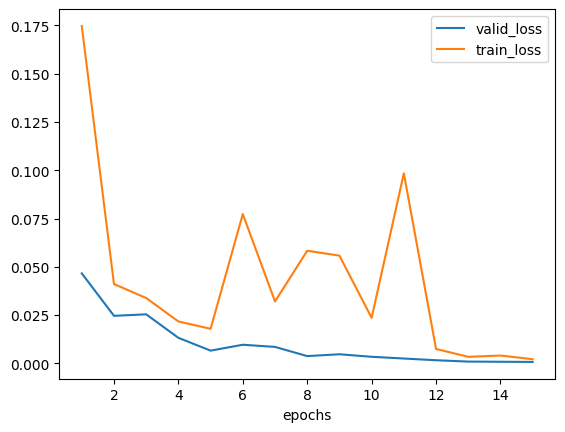

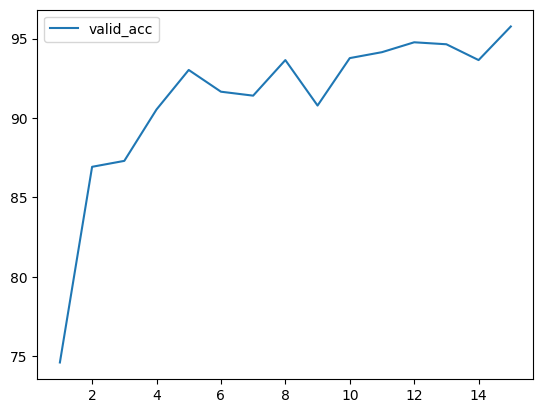

In [53]:
x_axis = range(1,epochs+1)
plt.figure()
plt.plot(x_axis,vloss_list,label='valid_loss')
plt.plot(x_axis,tloss_list,label='train_loss')
plt.xlabel('epochs')
plt.legend()
plt.show 
plt.figure()
plt.plot(x_axis,acc_list,label='valid_acc')
plt.legend()
plt.show()

**Evaluate on test data (here validation)**

Accuracy: 95.7659%


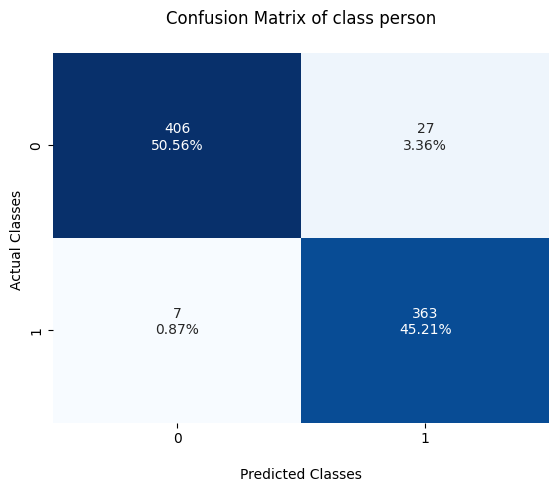

f1 score: 0.9552631578947368



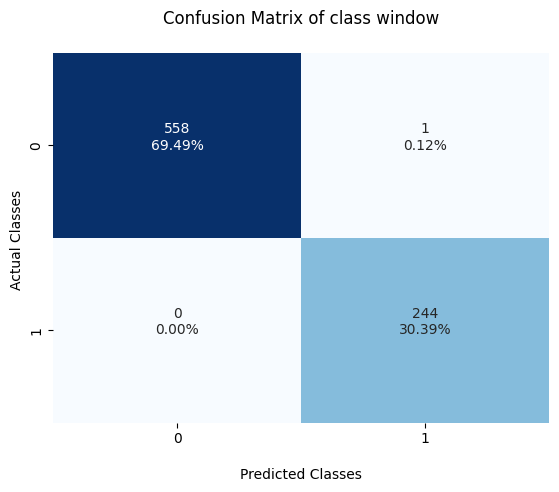

f1 score: 0.9979550102249488



In [54]:
#for person
yp_true = []
yp_pred = []

# for window
yw_true = []
yw_pred = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    for inputs, labels in vls:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predicted = torch.round(outputs)
        n_samples += labels.shape[0]
        n_correct += torch.all((predicted == labels),dim=1).sum().item()
    
        # for confusion matrix

        yp_pred.append(predicted[:,0].cpu().numpy())
        yp_true.append(labels[:,0].cpu().numpy())

        yw_pred.append(predicted[:,1].cpu().numpy())
        yw_true.append(labels[:,1].cpu().numpy())

        # for i in range(labels.shape[0]):
        #     if torch.unique(labels[i]).size(0)==1:
        #          y_true.append(1.0)
        #     else:
        #         y_true.append(0.0)
        #     if torch.unique(predicted[i]).size(0)==1:
        #          y_pred.append(1.0)
        #     else:
        #         y_pred.append(0.0)
                
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy: {acc:.4f}%')

yp_pred = [item for sublist in yp_pred for item in sublist]
yp_true = [item for sublist in yp_true for item in sublist]

yw_pred = [item for sublist in yw_pred for item in sublist]
yw_true = [item for sublist in yw_true for item in sublist]

### person class
### number of classes in validation set
n_classes = len(set(yp_true))
plot_confusion(yp_true,yp_pred,n_classes,name = 'person')
print(f'f1 score: {f1_score(yp_true,yp_pred)}\n') # to get f1 score for each class use (average=None)


### window class
### number of classes in validation set
n_classes = len(set(yw_true))
plot_confusion(yw_true,yw_pred,n_classes,name = 'window')
print(f'f1 score: {f1_score(yw_true,yw_pred)}\n') # to get f1 score for each class use (average=None)



epoch,train_loss,valid_loss,accuracy_multi,time
0,0.695314,0.689282,0.640722,00:00
1,0.665397,0.636714,0.700498,00:00
2,0.566702,0.485075,0.772727,00:00
3,0.442261,0.391131,0.851183,00:00
4,0.377231,0.348345,0.853051,00:00
5,0.344811,0.322683,0.852428,00:00
6,0.326495,0.308043,0.857410,00:00
7,0.312529,0.301417,0.859278,00:00
8,0.310238,0.298841,0.859900,00:00
9,0.309088,0.298503,0.863014,00:00


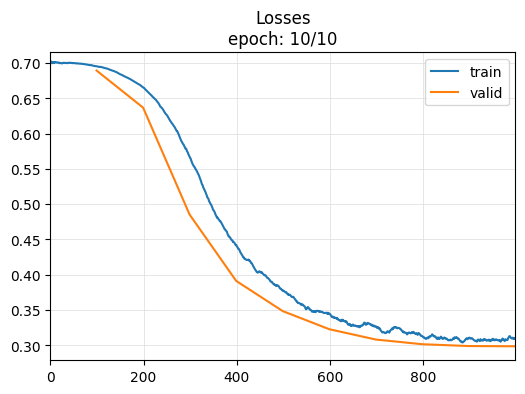

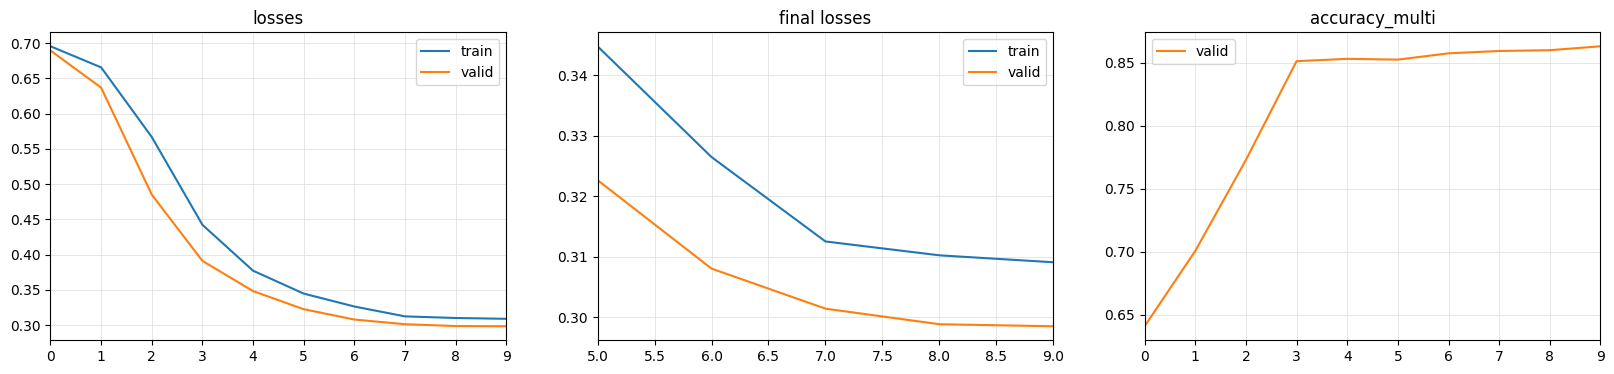

FlattenedLoss of BCEWithLogitsLoss()


In [57]:
######## remove standardization from above at first, also remove sigmoid from the network*****************

# splits = TimeSplitter()(y)
splits = TrainValidTestSplitter()(y)
tfms  = [None, MultiCategorize()] 
batch_tfms = TSStandardize()
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs = 32, num_workers=2)#,batch_tfms=batch_tfms) ### note the normalization

k={}
model = create_model(MyLSTM, dls.vars,dls.c,dls,**k)

#### note the accuracy_multi and MultiCategorize() contains BCEwithlogits not normal BCE
learn = Learner(dls, model, lr = 1e-4, metrics=accuracy_multi,cbs = ShowGraph())
learn.fit_one_cycle(10)

print(learn.loss_func)

##### save and load pkl model
# learn.export('models/learn.pkl')
# learn = load_learner('models/learn.pkl')

**Benchmarking**

In [ ]:
dsid = 'LSST' 

splits = TrainValidTestSplitter()(y)
tfms  = [None, MultiCategorize()] 
batch_tfms = TSStandardize()
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs = 32, num_workers=2)

archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), 
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
         (InceptionTime, {}), (XceptionTime, {})]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):
    model = create_model(arch,dls.vars,dls.c, dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy_multi)
    start = time.time()
    learn.fit_one_cycle(10, 1e-4)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    display(results)

**EVALUATION ON TEST DATA SET**

torch.Size([803, 2]) torch.Size([803, 2])
Accuracy: 73.22540


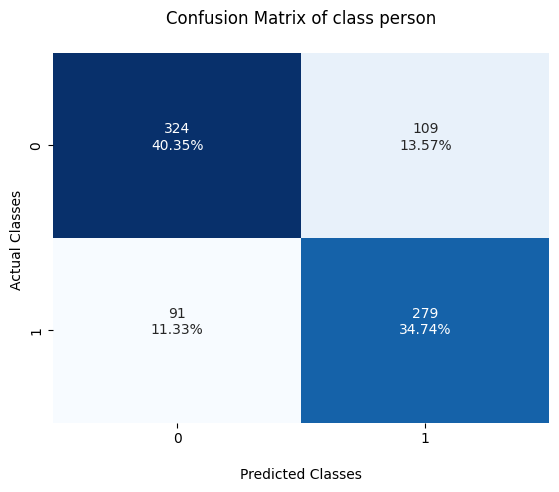

f1 score: 0.7361477572559366



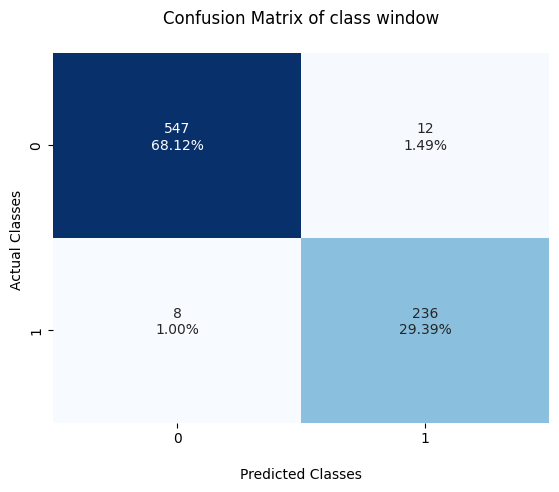

f1 score: 0.959349593495935



In [58]:
#### Adding dataset to apply same dls valid tfms on test

test_ds = dls.valid.dataset.add_test(X[splits[1]], y[splits[1]]) #X and y would be your test data (segmented)
test_dl = dls.valid.new(test_ds)
next(iter(test_dl))

#### evaluating

test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True)#,reorder = False)

print(test_targets.shape,test_preds.shape)
# print(f'Accuracy: {(test_targets == test_preds).float().mean():0.5f}') ## single label 
# print(f'f1 score: {f1_score(test_targets,test_preds,average=None)}\n') # to get f1 score for each class use (average=None)
# ### number of classes in validation set
# n_classes = pd.DataFrame(test_targets).value_counts().shape[0]
# plot_confusion(test_targets,test_preds,n_classes)


print(f'Accuracy: {(100/test_targets.shape[0])*torch.all((test_preds == test_targets),dim=1).sum():0.5f}') ## multi-label
n_classes = test_targets.shape[1]
plot_confusion(test_targets[:,0],test_preds[:,0],n_classes,name = 'person')
print(f'f1 score: {f1_score(test_targets[:,0],test_preds[:,0])}\n') # to get f1 score for each class use (average=None)


### window class
### number of classes in validation set
plot_confusion(test_targets[:,1],test_preds[:,1],n_classes,name = 'window')
print(f'f1 score: {f1_score(test_targets[:,1],test_preds[:,1])}\n') # to get f1 score for each class use (average=None)


In [ ]:
learn.feature_importance()

In [252]:
model.state_dict

<bound method Module.state_dict of MyFCN(
  (convblock1): ConvBlock(
    (0): Conv1d(17, 16, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock2): ConvBlock(
    (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock3): ConvBlock(
    (0): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (gap): GAP1d(
    (gap): AdaptiveAvgPool1d(output_size=1)
    (flatten): fastai.layers.Flatten(full=False)
  )
  (fc): Linear(in_features=16, out_features=2, bias=True)
)>

In [ ]:
m=np.array(learn.recorder.values)
m.shape
import matplotlib.pyplot as plt

In [ ]:
plt.figure()
plt.plot(m[:,0])
plt.plot(m[:,1])
plt.show()

**optuna for HP optimization**

In [ ]:
import optuna
from optuna.integration import FastAIPruningCallback

num_epochs = 5
num_optuna_trials = 50
    
def objective(trial:optuna.Trial):
    # Define search space here. Supported search space are 
    #num_filters = trial.suggest_categorical('num_filters', [32, 64, 96, 128]) 
    #dropout_rate = trial.suggest_float("dropout_rate", 0.0, 1.0)
    lr = trial.suggest_float("Learning_rate", 1e-8, 1e-6, log=True)
    
    learn = TSClassifier(X, y, splits=splits,lr =  lr, path='models', arch=InceptionTimePlus, arch_config=dict(depth=4,act=nn.ReLU, fc_dropout=0.5), batch_tfms=batch_tfms, metrics=accuracy, cbs=[ShowGraph(),FastAIPruningCallback(trial)])

    
    learn.fit_one_cycle(num_epochs, lr_max=1e-3)
            
    # return the valid_loss - learn.recorder.values returns [[train_loss, valid_loss, acc]]
    return learn.recorder.values[-1][1]

In [ ]:
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=num_optuna_trials, show_progress_bar=False)

In [ ]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

**calculate time**

In [ ]:
import timeit

start = timeit.default_timer()



 
learn = TSClassifier(X, y, splits=splits, lr=1e-5,path='models', arch=LSTMPlus , batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(10)
stop = timeit.default_timer()

print('Time: ', stop - start) 